In [1]:

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras import layers, models
#from numpy.random import seed
#seed(1)
#import tensorflow
#tensorflow.random.set_seed(2)



In [2]:
# importing training data

data_path = "../Training/"
all_files = os.listdir(data_path)




from sklearn.model_selection import train_test_split


jpg_files = list(filter(lambda f: f.endswith('.jpg'), all_files))


# Split into training and validation sets
training_files, validation_files = train_test_split(jpg_files, test_size=0.2, random_state=42)






#Data size for training 
print("Training data size ",len(training_files))

# importing validation data

#validation_data_path = "Validation/"
#validation_files = os.listdir(validation_data_path)
#validation_files = list(filter(lambda f: f.endswith('.jpg'), validation_files))

#Data size for training 
print("Validation data size ",len(validation_files))


Training data size  3830
Validation data size  958


In [3]:
def ratios_to_categories(argument):
    switcher = {
        0:0.891,
        5:1.055,
        10:1.228,
        15:1.482,
        20:1.763,
        25:1.975,
        30:2.302,
        35:2.598,
        40:2.904,
        45:3.222,
        50:3.691,
        75:1.084,
        425:2.931,
        275:2.102
    }
    return switcher.get(argument, "nothing")


In [4]:
train_images = []
train_labels = []
val_images   = []
val_labels   = []
for trainingf_name in training_files:
    trainingratio = trainingf_name.split('-')[0]
    train_images.append(mpimg.imread(data_path +trainingf_name))
    train_labels.append(ratios_to_categories(int(trainingratio)))

for validationf_name in validation_files:
    validationratio = validationf_name.split('-')[0]
    #in case validation folder change data_path to validation data path
    val_images.append(mpimg.imread(data_path +validationf_name))
    val_labels.append(ratios_to_categories(int(validationratio)))
    
    


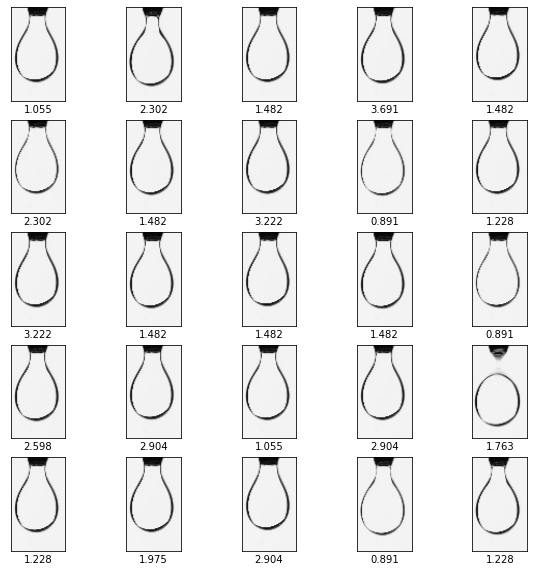

In [5]:
# Show the first 10 images

current=0
plt.figure(figsize=(10,10))

for i in range(25):

    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(train_labels[i])
plt.show()


In [6]:
def unique(list1):
 
    # initialize a null list
    unique_list = []
 
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    # print list
    for x in unique_list:
        print (x)

        
#unique(train_labels)


In [7]:
image_height=91
image_width=53

train_images = np.array(train_images)
train_labels = np.array(train_labels)
val_images   = np.array(val_images)
val_labels   = np.array(val_labels)

print(train_images.shape)
print(val_images.shape)

#unique(val_labels)

(3830, 91, 53, 3)
(958, 91, 53, 3)


In [8]:
from itertools import groupby
print('Training labels occurances:',[len(list(group)) for key, group in groupby(sorted(train_labels))])

label_counts = [(key, len(list(group))) for key, group in groupby(sorted(train_labels))]
print('Training label occurrences:')
for label, count in label_counts:
    print("Viscosity "f'{label}: Number of Sample = {count}')

print('Validation Labels occurances:',[len(list(group)) for key, group in groupby(sorted(val_labels))])

label_counts = [(key, len(list(group))) for key, group in groupby(sorted(val_labels))]
print('Training label occurrences:')
for label, count in label_counts:
    print("Viscosity "f'{label}: Number of Sample = {count}')


Training labels occurances: [333, 352, 385, 367, 327, 351, 328, 345, 363, 335, 344]
Training label occurrences:
Viscosity 0.891: Number of Sample = 333
Viscosity 1.055: Number of Sample = 352
Viscosity 1.228: Number of Sample = 385
Viscosity 1.482: Number of Sample = 367
Viscosity 1.763: Number of Sample = 327
Viscosity 1.975: Number of Sample = 351
Viscosity 2.302: Number of Sample = 328
Viscosity 2.598: Number of Sample = 345
Viscosity 2.904: Number of Sample = 363
Viscosity 3.222: Number of Sample = 335
Viscosity 3.691: Number of Sample = 344
Validation Labels occurances: [104, 98, 88, 80, 67, 89, 65, 97, 77, 100, 93]
Training label occurrences:
Viscosity 0.891: Number of Sample = 104
Viscosity 1.055: Number of Sample = 98
Viscosity 1.228: Number of Sample = 88
Viscosity 1.482: Number of Sample = 80
Viscosity 1.763: Number of Sample = 67
Viscosity 1.975: Number of Sample = 89
Viscosity 2.302: Number of Sample = 65
Viscosity 2.598: Number of Sample = 97
Viscosity 2.904: Number of Sam

In [9]:
# Normalize pixel values between 0 and 1
train_images, val_images = train_images / 255.0, val_images / 255.0

In [11]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
import numpy as np

# Assuming you have your data loaded in train_images, train_labels, val_images, val_labels

# Define your model
def build_model():
    model = Sequential()
    model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(91, 53, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (5, 5), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer='adam', loss='mse')
    return model

# Convert data to numpy arrays if not already done
train_images = np.array(train_images)
train_labels = np.array(train_labels)
val_images = np.array(val_images)
val_labels = np.array(val_labels)

# Set up K-Fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Store the results for each fold
all_histories = []
foldscores = []  
# Iterate over folds
for fold, (train_indices, val_indices) in enumerate(kfold.split(train_images)):
    print(f"Training on fold {fold + 1}...")

    # Create a new model for each fold
    model = build_model()

    # Get the data for the current fold
    fold_train_images, fold_train_labels = train_images[train_indices], train_labels[train_indices]
    fold_val_images, fold_val_labels = train_images[val_indices], train_labels[val_indices]

    # Set up early stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')

    # Train the model on the current fold
    history = model.fit(fold_train_images, fold_train_labels, epochs=100,
                        validation_data=(fold_val_images, fold_val_labels), callbacks=[early_stop])
    
    print(f"Results on fold {fold + 1}...")
    pred_train= model.predict(fold_train_images)
    scores = model.evaluate(fold_train_images, fold_train_labels, verbose=0)
    print('Error on training data',scores)
    pred_valid= model.predict(val_images)
    scores1 = model.evaluate(fold_val_images, fold_val_labels, verbose=0)
    print('Error on validation data,',scores1)

    # Store the training history for later analysis
    all_histories.append(history)
    
    # Append the results to the list
    foldscores.append({
        'fold': fold + 1,
        'scores_train': scores,
        'pred_valid': pred_valid,
        'scores_valid': scores1
    })

# Perform analysis on all_histories as needed (e.g., plot learning curves, calculate metrics, etc.)


Training on fold 1...
Epoch 1/100
96/96 [==============================] - 12s 123ms/step - loss: 1.4172 - val_loss: 0.7359
Epoch 2/100
96/96 [==============================] - 13s 138ms/step - loss: 0.8608 - val_loss: 0.7644
Epoch 3/100
96/96 [==============================] - 14s 142ms/step - loss: 0.8101 - val_loss: 0.5990
Epoch 4/100
96/96 [==============================] - 13s 139ms/step - loss: 0.5910 - val_loss: 0.2695
Epoch 5/100
96/96 [==============================] - 13s 139ms/step - loss: 0.3310 - val_loss: 0.1313
Epoch 6/100
96/96 [==============================] - 13s 137ms/step - loss: 0.2774 - val_loss: 0.1347
Epoch 7/100
96/96 [==============================] - 13s 138ms/step - loss: 0.2391 - val_loss: 0.2266
Epoch 8/100
96/96 [==============================] - 13s 137ms/step - loss: 0.2028 - val_loss: 0.0599
Epoch 9/100
96/96 [==============================] - 13s 139ms/step - loss: 0.1902 - val_loss: 0.0669
Epoch 10/100
96/96 [==============================] - 13s 13

Epoch 17/100
96/96 [==============================] - 13s 133ms/step - loss: 0.1585 - val_loss: 0.0414
Epoch 18/100
96/96 [==============================] - 13s 133ms/step - loss: 0.1554 - val_loss: 0.0334
Epoch 19/100
96/96 [==============================] - 13s 135ms/step - loss: 0.1518 - val_loss: 0.0271
Epoch 20/100
96/96 [==============================] - 13s 133ms/step - loss: 0.1461 - val_loss: 0.0292
Epoch 21/100
96/96 [==============================] - 13s 133ms/step - loss: 0.1400 - val_loss: 0.0260
Epoch 22/100
96/96 [==============================] - 13s 132ms/step - loss: 0.1384 - val_loss: 0.0330
Epoch 23/100
96/96 [==============================] - 13s 134ms/step - loss: 0.1267 - val_loss: 0.0351
Epoch 24/100
96/96 [==============================] - 13s 134ms/step - loss: 0.1261 - val_loss: 0.0305
Epoch 25/100
96/96 [==============================] - 13s 136ms/step - loss: 0.1189 - val_loss: 0.0403
Epoch 26/100
96/96 [==============================] - 13s 134ms/step - lo

96/96 [==============================] - 13s 136ms/step - loss: 0.0785 - val_loss: 0.0213
Epoch 41/100
96/96 [==============================] - 13s 132ms/step - loss: 0.0707 - val_loss: 0.0161
Epoch 42/100
96/96 [==============================] - 13s 134ms/step - loss: 0.0707 - val_loss: 0.0153
Epoch 43/100
96/96 [==============================] - 13s 137ms/step - loss: 0.0661 - val_loss: 0.0165
Epoch 44/100
96/96 [==============================] - 13s 135ms/step - loss: 0.0680 - val_loss: 0.0196
Epoch 45/100
96/96 [==============================] - 13s 136ms/step - loss: 0.0625 - val_loss: 0.0144
Epoch 46/100
96/96 [==============================] - 13s 136ms/step - loss: 0.0664 - val_loss: 0.0290
Epoch 47/100
96/96 [==============================] - 13s 135ms/step - loss: 0.0680 - val_loss: 0.0166
Epoch 48/100
96/96 [==============================] - 13s 135ms/step - loss: 0.0642 - val_loss: 0.0141
Epoch 49/100
96/96 [==============================] - 13s 134ms/step - loss: 0.0669 - 

96/96 [==============================] - 13s 132ms/step - loss: 0.0924 - val_loss: 0.0223
Epoch 38/100
96/96 [==============================] - 13s 135ms/step - loss: 0.1011 - val_loss: 0.0276
Epoch 39/100
96/96 [==============================] - 13s 132ms/step - loss: 0.0875 - val_loss: 0.0222
Epoch 40/100
96/96 [==============================] - 13s 133ms/step - loss: 0.0874 - val_loss: 0.0216
Epoch 41/100
96/96 [==============================] - 13s 134ms/step - loss: 0.0847 - val_loss: 0.0440
Epoch 42/100
96/96 [==============================] - 13s 132ms/step - loss: 0.0794 - val_loss: 0.0254
Epoch 43/100
96/96 [==============================] - 13s 134ms/step - loss: 0.0801 - val_loss: 0.0197
Epoch 43: early stopping
Results on fold 5...
96/96 [==============================] - 3s 34ms/step
Error on training data 0.016306357458233833
30/30 [==============================] - 1s 35ms/step
Error on validation data, 0.019671041518449783


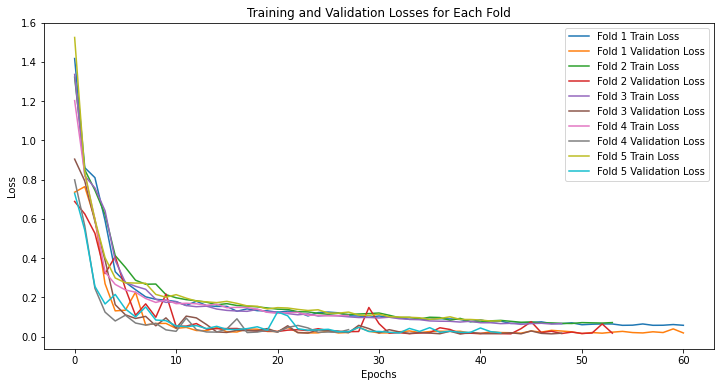

C:\Users\mmrad\anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


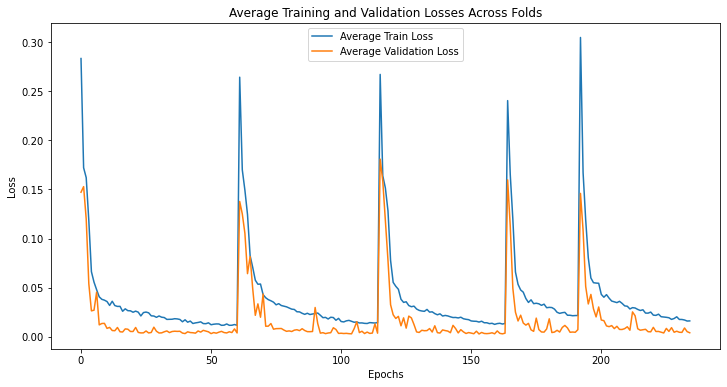

Average Training Loss across Folds: 0.01602043807506561
Average Validation Loss across Folds: 0.003934208303689957


In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Plot training and validation losses for each fold
plt.figure(figsize=(12, 6))

for fold, history in enumerate(all_histories):
    plt.plot(history.history['loss'], label=f'Fold {fold + 1} Train Loss')
    plt.plot(history.history['val_loss'], label=f'Fold {fold + 1} Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses for Each Fold')
plt.legend()
plt.show()

# Get the average performance metrics across all folds
all_train_losses = [history.history['loss'] for history in all_histories]
all_val_losses = [history.history['val_loss'] for history in all_histories]

average_train_loss = np.mean(all_train_losses, axis=0)
average_val_loss = np.mean(all_val_losses, axis=0)

# Plot average training and validation losses
plt.figure(figsize=(12, 6))
plt.plot(average_train_loss, label='Average Train Loss')
plt.plot(average_val_loss, label='Average Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Average Training and Validation Losses Across Folds')
plt.legend()
plt.show()

print("Average Training Loss across Folds:", average_train_loss[-1])
print("Average Validation Loss across Folds:", average_val_loss[-1])


In [13]:

pred_train= model.predict(train_images)
scores = model.evaluate(train_images, train_labels, verbose=0)
print('Error on training data',scores)
pred_valid= model.predict(val_images)
scores1 = model.evaluate(val_images, val_labels, verbose=0)
print('Error on validation data,',scores1)




120/120 [==============================] - 4s 31ms/step
Error on training data 0.016979290172457695
30/30 [==============================] - 1s 30ms/step
Error on validation data, 0.023176737129688263


In [14]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

mae = mean_absolute_error(train_labels, pred_train)
mse = mean_squared_error(train_labels, pred_train)
rmse = np.sqrt(mse)
r2 = r2_score(train_labels, pred_train)

# Print the results
print("Training Error Measurements")
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 score:", r2)

Training Error Measurements
MAE: 0.100221097284571
MSE: 0.016979287011916762
RMSE: 0.130304593211125
R2 score: 0.9781221844707749


In [15]:

mae = mean_absolute_error(val_labels, pred_valid)
mse = mean_squared_error(val_labels, pred_valid)
rmse = np.sqrt(mse)
r2 = r2_score(val_labels, pred_valid)

# Print the results
print("Validataion Error Measurements")
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 score:", r2)

Validataion Error Measurements
MAE: 0.10219606966016685
MSE: 0.023176732363501137
RMSE: 0.15223906319831693
R2 score: 0.972358489378015


In [16]:
#TESTING ON SPECIFIC SAMPLES 0.257 , 0.425, 0.075 UNSEEN DATA 
testdata_path = "../Testing/"
alltest_files = os.listdir(testdata_path)
test_files = list(filter(lambda f: f.endswith('.jpg'), alltest_files))

#Data size for training 
len(test_files)


1286

In [17]:
testimages = []
test_images_labels = []
for testf_name in test_files:
    testratio = testf_name.split('-')[0]
    testimages.append(mpimg.imread(testdata_path +testf_name))
    test_images_labels.append(ratios_to_categories(int(testratio)))

from itertools import groupby
print([len(list(group)) for key, group in groupby(sorted(test_images_labels))])


# Normalize pixel values between 0 and 1
testimages = np.array(testimages) / 255.0

unique(test_images_labels)

label_counts = [(key, len(list(group))) for key, group in groupby(sorted(test_images_labels))]
print('Testing label occurrences:')
for label, count in label_counts:
    print("Viscosity "f'{label}: Number of Sample = {count}')


[425, 422, 439]
1.084
2.102
2.931
Testing label occurrences:
Viscosity 1.084: Number of Sample = 425
Viscosity 2.102: Number of Sample = 422
Viscosity 2.931: Number of Sample = 439


In [18]:
pred_test= model.predict(testimages)
#scores2 = model.evaluate(testimages, test_images_labels, verbose=0)

#print (pred_test)

#print('Error on validation data,',scores2)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Calculate the evaluation metrics
mae = mean_absolute_error(test_images_labels, pred_test)
mse = mean_squared_error(test_images_labels, pred_test)
rmse = np.sqrt(mse)
r2 = r2_score(test_images_labels, pred_test)

# Print the results
print("Testing Error Measurements")
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 score:", r2)





41/41 [==============================] - 1s 32ms/step
Testing Error Measurements
MAE: 0.12185625187827863
MSE: 0.035236443005225604
RMSE: 0.1877137262035614
R2 score: 0.938637441657321


In [19]:
total=0
count=0
#1.084:2.102:2.931
for i in range(len(pred_test)):
    #if(test_images_labels[i]==2.931):
    count+=1
    PercentError= (test_images_labels[i]-pred_test[i])/(test_images_labels[i])*100
    total=total+abs(PercentError)

print(count)
print("Prediction accuracy on Test Set :",100-total/len(pred_test))


1286
Prediction accuracy on Test Set : [93.752]


In [20]:
total=0

for i in range(len(pred_test)):
    PercentError= (test_images_labels[i]-pred_test[i])/(test_images_labels[i])*100
    total=total+abs(PercentError)
print("Prediction accuracy on Test Set :",100-total/len(pred_test))

Prediction accuracy on Test Set : [93.752]


In [21]:
total=0

for i in range(len(pred_train)):
    PercentError= (train_labels[i]-pred_train[i])/(train_labels[i])*100
    total=total+abs(PercentError)
print("Prediction accuracy on training Set :",100-total/len(pred_train))

Prediction accuracy on training Set : [94.05267]


In [22]:
total=0

for i in range(len(pred_valid)):
    PercentError= (val_labels[i]-pred_valid[i])/(val_labels[i])*100
    total=total+abs(PercentError)
print("Prediction accuracy on validation Set :",100-total/len(pred_valid))

Prediction accuracy on validation Set : [93.88801]


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


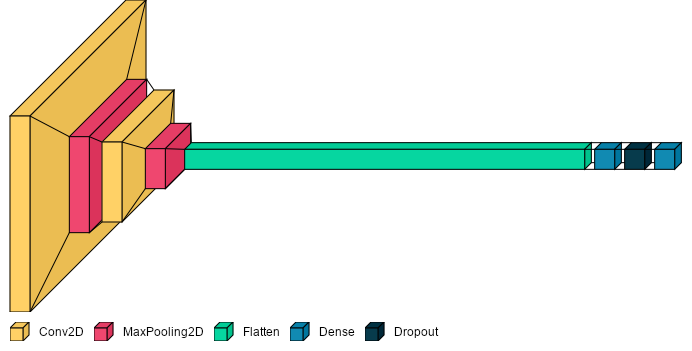

In [23]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
import visualkeras
visualkeras.layered_view(model)
visualkeras.layered_view(model, legend=True) # without custom font
from PIL import ImageFont
font = ImageFont.truetype("arial.ttf", 12)
visualkeras.layered_view(model, legend=True, font=font) # selected font

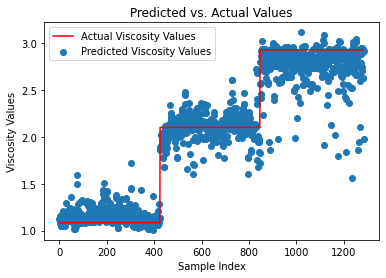

In [24]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Create a scatter plot for predicted values
plt.scatter(range(len(pred_test)), pred_test, label='Predicted Viscosity Values')
plt.plot(range(len(test_images_labels)), test_images_labels, c='red', label='Actual Viscosity Values')
plt.xlabel('Sample Index')
plt.ylabel('Viscosity Values')
plt.title('Predicted vs. Actual Values')


plt.legend()
plt.show()

In [34]:
for fold_result in foldscores:
    fold_number = fold_result['fold']
    scores_train_fold = fold_result['scores_train']
    pred_valid_fold = fold_result['pred_valid']
    scores_valid_fold = fold_result['scores_valid']
    
    print(f"Fold {fold_number}:")
    print(f"Scores on training data: {scores_train_fold}")

    print(f"Scores on validation data: {scores_valid_fold}")
    print("\n")


Fold 1:
Scores on training data: 0.01603933796286583
Scores on validation data: 0.018719037994742393


Fold 2:
Scores on training data: 0.016732333227992058
Scores on validation data: 0.017580769956111908


Fold 3:
Scores on training data: 0.014996345154941082
Scores on validation data: 0.017569897696375847


Fold 4:
Scores on training data: 0.034434136003255844
Scores on validation data: 0.03549885377287865


Fold 5:
Scores on training data: 0.016306357458233833
Scores on validation data: 0.019671041518449783




In [35]:
import numpy as np
from scipy.stats import sem, t

# Assuming 'foldscores' contains the results for each fold

all_scores_train = [fold_result['scores_train'] for fold_result in foldscores]
all_scores_valid = [fold_result['scores_valid'] for fold_result in foldscores]

# Calculate mean
mean_scores_train = np.mean(all_scores_train)
mean_scores_valid = np.mean(all_scores_valid)

# Calculate standard deviation
std_scores_train = np.std(all_scores_train)
std_scores_valid = np.std(all_scores_valid)

# Calculate 95% confidence interval
confidence_interval_train = t.interval(0.95, len(all_scores_train)-1, loc=mean_scores_train, scale=sem(all_scores_train))
confidence_interval_valid = t.interval(0.95, len(all_scores_valid)-1, loc=mean_scores_valid, scale=sem(all_scores_valid))

# Print the results
print("Training Data:")
print(f"Mean: {mean_scores_train}")
print(f"Standard Deviation: {std_scores_train}")
print(f"95% Confidence Interval: {confidence_interval_train}")

print("\nValidation Data:")
print(f"Mean: {mean_scores_valid}")
print(f"Standard Deviation: {std_scores_valid}")
print(f"95% Confidence Interval: {confidence_interval_valid}")


Training Data:
Mean: 0.019701701961457728
Standard Deviation: 0.0073884155338151195
95% Confidence Interval: (0.009444936889443544, 0.029958467033471912)

Validation Data:
Mean: 0.021807920187711716
Standard Deviation: 0.0068902647235098945
95% Confidence Interval: (0.01224269930515866, 0.03137314107026477)
